## Substitution Effect

대체 효과는 두 가지 특성이 예측 정보를 공유할 때 발생한다. 대체 효과는 feature importance 방법의 결과를 편향시킬 수 있다. MDI의 경우 동일한 두 특성이 동일한 확률로 무작위로 선택되기 때문에 그들의 중요도는 반감될 것이다. MDA의 경우 한 가지 특성을 셔플링하는 효과가 다른 효과에 의해 보상될 수 있기 때문에 동일한 두 가지 특성이 중요하더라도 중요하지 않은 것으로 간주될 수 있다.

In [1]:
import pandas as pd
import numpy as np

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

In [2]:
trnsX, cont = get_test_data(
    n_features = 20, 
    n_informative = 5, 
    n_redundant = 5, 
    n_samples = 1000
)

### Clustered Feature Importance

기저 변경이 필요하지 않은 더 나은 접근 방식은 유사한 특성을 군집화하고 군집 수준에서 특성 중요도 분석을 적용하는 것이다. 구성상 군집은 서로 달라서 substitution effect를 완화시키기 때문이다. 분석은 기저의 변경 없이 특성의 분할에 대해 행해지기 때문에 결과는 보통 직관적이다. Clustered Feature Importance 알고리즘에는 다음의 두 단계가 포함된다.

1. 특성 군집의 수와 구성 요소를 찾는다
2. 개별 특성보다는 유사한 특성의 그룹에 대해 특성 중요도 분석을 적용한다

#### Clustered Mean Decrease Importance

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from FinancialMachineLearning.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

#### Clustered Mean Decrease Accuracy

In [4]:
def group_mean_std(df0, clstrs) -> pd.DataFrame :
    out = pd.DataFrame(columns = ['mean','std'])
    for i, j in clstrs.items() :
        df1 = df0[j].sum(axis = 1)
        out.loc['C_' + str(i), 'mean'] = df1.mean()
        out.loc['C_' + str(i), 'std'] = df1.std() * df1.shape[0] ** (-0.5)
    return out

def clustered_mean_decrease_importance(fit, feature_names, clstrs) -> pd.DataFrame :
    df0 = {
        i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient = 'index')
    df0.columns = feature_names
    df0 = df0.replace(0, np.nan)
    imp = group_mean_std(df0, clstrs)
    imp /= imp['mean'].sum()
    return imp

In [5]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase
corr0, clusters, silh = clusterKMeansBase(trnsX.corr(), maxNumClusters = 10, n_init = 10)

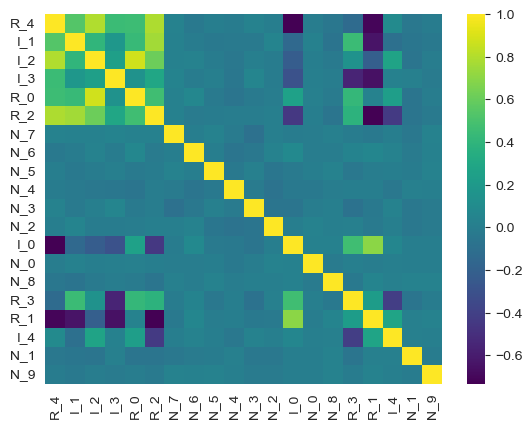

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr0, cmap = 'viridis')
plt.show()

In [7]:
c_mdi = clustered_mean_decrease_importance(fit, trnsX.columns, clstrs = clusters)

In [8]:
c_mdi

,mean,std
C_0,0.35126,0.003162
C_1,0.64874,0.003162
